## Import Modules

In [1]:
import os
from time import time
import numpy as np
from copy import deepcopy
import cv2 as cv
import matplotlib.pyplot as plt
from time import time
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from utils import *
import models

## Prepare Data

In [2]:
def trans(image):
    image = image if image.shape[0] > image.shape[1] else image.transpose(1, 0, 2)
    image = image.astype(np.float32)
    image /= 255
    image -= [0.485, 0.456, 0.406]
    image /= [0.229, 0.224, 0.225]
    image = cv.resize(image, (224, 224))
    image = image.transpose(2, 0, 1)
    return image

In [3]:
dataset = TotalDataset(r'G:\Datasets\PCB-dataset\14', transforms=trans)

Loading dataset "14"
Loading class: abnormal ****************************** 1335/1335 Finished! Time used: 45.656s
Loading class: normal ****************************** 2367/2367 Finished! Time used: 165.844s


In [4]:
dataset.reset()
train_dataset = dataset.selectData(1800, 0.5, augmentation=1)
val_dataset = dataset.selectData(40, 0.5)
test_dataset = dataset.selectData(500, 0.5)
train_dataset.shuffle()
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

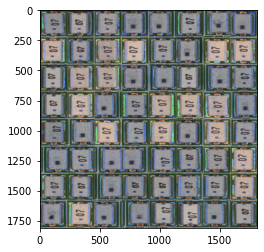

In [5]:
from torchvision.utils import make_grid
data, labels = next(iter(train_dataloader))
display = make_grid(data)
display = display.numpy().transpose((1, 2, 0))
display *= [0.229, 0.224, 0.225]
display += [0.485, 0.456, 0.406]
display = np.clip(display, 0, 1)
plt.imshow(display)


## Create Model

In [6]:
model = models.resnet18()

In [14]:
237/24/6

1.6458333333333333

In [91]:
model = models.seNet()

In [7]:
learning_rate = 1e-4
weight_decay = 1e-6
# loss_threshold = 0.02
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}')

model.to(device)
criterion = CrossEntropyLoss(weight=torch.tensor([5., 1.])).to('cuda')
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Using device cuda


## Train and Validate

In [93]:
from pytorch_metric_learning import miners, losses
miner = miners.MultiSimilarityMiner()
loss_func = losses.TripletMarginLoss()

epochs = 100

best_model = None
best_acc = 0
best_loss = None

loss_table = []
re_report_table = []

start = time()
print('Training Starts!')
for epoch in range(epochs):
    model.train()
    for step, (data, labels) in enumerate(train_dataloader):
        data, labels = data.to(device), labels.to(device).long()
        # outputs = model(data)
        # loss = criterion(outputs, labels)

        embeddings = model(data)
        hard_pairs = miner(embeddings, labels)
        loss = loss_func(embeddings, labels, hard_pairs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_table.append(loss.item())
    
    model.eval()
    # correct = count = loss_value = 0
    p = []
    l = []
    loss_value = 0
    for step, (data, labels) in enumerate(val_dataloader):
        data, labels = data.to(device), labels.to(device).long()
        outputs = model(data)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        # correct += (predicted == labels).sum().item()
        # count += labels.size(0)
        loss_value += loss.item()
        p += predicted.detach().cpu().numpy().tolist()
        l += labels.detach().cpu().numpy().tolist() 

    # accuracy = correct / count * 100
    # accuracy_table.append(accuracy)
    report = classification_report(l, p, output_dict=True, digits=4)
    accuracy = report['accuracy']
    if accuracy > best_acc:
    # if best_loss is None or loss_value < best_loss:
        best_acc = accuracy
        best_model = deepcopy(model.state_dict())
    print(f'Epoch:  {epoch + 1}', 'Loss:  %.4f' % loss_value,
          'Accuracy:  %.2f' % accuracy, 'Time used:  %.2f' % (time() - start) + 's', sep='\t')
    re_report_table.append(report)

Training Starts!


e:\Python Virtual Environments\pytorch_cuda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python Virtual Environments\pytorch_cuda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python Virtual Environments\pytorch_cuda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Epoch:  1	Loss:  0.9426	Accuracy:  0.50	Time used:  12.59s
Epoch:  2	Loss:  0.4206	Accuracy:  0.88	Time used:  21.17s
Epoch:  3	Loss:  0.2652	Accuracy:  0.95	Time used:  29.75s
Epoch:  4	Loss:  0.1807	Accuracy:  1.00	Time used:  38.33s
Epoch:  5	Loss:  0.1156	Accuracy:  1.00	Time used:  46.96s
Epoch:  6	Loss:  0.0877	Accuracy:  1.00	Time used:  55.60s
Epoch:  7	Loss:  0.0630	Accuracy:  1.00	Time used:  64.27s
Epoch:  8	Loss:  0.0580	Accuracy:  1.00	Time used:  72.95s
Epoch:  9	Loss:  0.0539	Accuracy:  1.00	Time used:  81.64s
Epoch:  10	Loss:  0.0318	Accuracy:  1.00	Time used:  90.39s


KeyboardInterrupt: 

1489

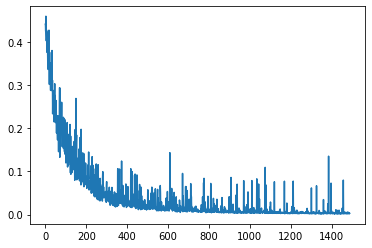

In [86]:
plt.plot(loss_table[:])
len(loss_table)

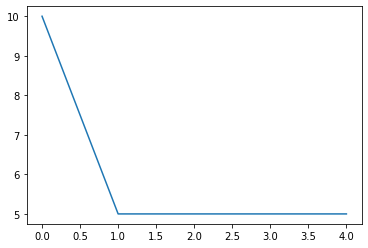

In [87]:
plt.plot([100 * (1 - report['accuracy']) for report in re_report_table])

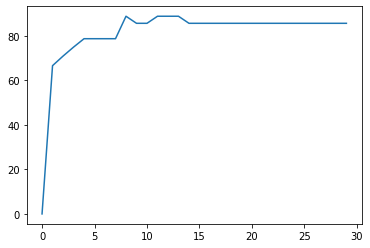

In [42]:
plt.plot([100 * (report['0']['f1-score']) for report in re_report_table])

## Test and Evaluation

In [94]:
model.eval()
model.load_state_dict(best_model)
p = []
l = []
for step, (data, labels) in enumerate(test_dataloader):
    data, labels = data.to(device), labels.to(device).long()
    outputs = model(data)
    loss = criterion(outputs, labels)

    _, predicted = torch.max(outputs.data, 1)
    p += predicted.detach().cpu().numpy().tolist()
    l += labels.detach().cpu().numpy().tolist()
test_report = classification_report(l, p, digits=4)
print(test_report)

              precision    recall  f1-score   support

           0     0.8869    0.9720    0.9275       250
           1     0.9690    0.8760    0.9202       250

    accuracy                         0.9240       500
   macro avg     0.9279    0.9240    0.9238       500
weighted avg     0.9279    0.9240    0.9238       500



In [ ]:
res = []
sers = []
crosss = []

In [ ]:
sers.append(test_report)

In [ ]:
from pickle import dump

network_name = 'SENet-WeightedLoss'
torch.save(model, f'saved_models/{network_name}_model.pt')
with open(f'saved_models/{network_name}_loss_table.list', 'wb') as file:
    dump(loss_table, file)
with open(f'saved_models/{network_name}_report_table.list', 'wb') as file:
    dump(report_table, file)
with open(f'saved_models/{network_name}_test_report.report', 'wb') as file:
    dump(test_report, file)

In [ ]:
report = classification_report(l, p, output_dict=True)
import pandas as pd
pd.DataFrame(report)

In [ ]:
report

In [ ]:
exam_data, exam_labels = folderDatasetToArray(r'G:\Datasets\PCB-dataset\11', transforms=trans)
_, _, exam_dataset = splitTrainValTest(exam_data, exam_labels, 0, 1)
exam_dataloader = DataLoader(exam_dataset, batch_size=64)

In [ ]:
model.eval()
model.load_state_dict(best_model)
pred_list = []
label_list = []
for step, (data, labels) in enumerate(exam_dataloader):
    data, labels = data.to(device), labels.to(device).long()
    outputs = model(data)
    loss = criterion(outputs, labels)

    _, predicted = torch.max(outputs.data, 1)
    pred_list += predicted.detach().cpu().numpy().tolist()
    label_list += labels.detach().cpu().numpy().tolist()
print(classification_report(label_list, pred_list))

In [ ]:
data, labels = next(iter(train_dataloader))

In [ ]:
image = cv.imread(r'\\LAPTOP-PO1B3AOS\Datasets\PCB-2020\sample\0\1.png')

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter

In [ ]:
images, labels = next(iter(train_dataloader))

In [ ]:
model

In [ ]:
models.resnet18()

In [ ]:
wei_reports = []

for i in range(5):
    train_dataset, val_dataset, test_dataset = splitTrainValTest(full_data, full_labels, 0.1, 0.8)

    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=64)
    test_dataloader = DataLoader(test_dataset, batch_size=64)

    model = models.seNet()

    learning_rate = 1e-5
    weight_decay = 1e-5
    # loss_threshold = 0.02
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Using device {device}')

    model.to(device)
    criterion = CrossEntropyLoss(weight=torch.tensor([10., 1.])).to('cuda')
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    epochs = 100

    best_model = None
    best_acc = 0
    best_loss = None

    loss_table = []
    report_table = []

    start = time()
    print('Training Starts!')
    for epoch in range(epochs):
        model.train()
        for step, (data, labels) in enumerate(train_dataloader):
            data, labels = data.to(device), labels.to(device).long()
            outputs = model(data)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_table.append(loss.item() / len(labels))
        
        model.eval()
        # correct = count = loss_value = 0
        p = []
        l = []
        loss_value = 0
        for step, (data, labels) in enumerate(val_dataloader):
            data, labels = data.to(device), labels.to(device).long()
            outputs = model(data)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            # correct += (predicted == labels).sum().item()
            # count += labels.size(0)
            loss_value += loss.item()
            p += predicted.detach().cpu().numpy().tolist()
            l += labels.detach().cpu().numpy().tolist() 

        # accuracy = correct / count * 100
        # accuracy_table.append(accuracy)
        report = classification_report(l, p, output_dict=True, digits=4)
        accuracy = report['accuracy']
        if accuracy > best_acc:
        # if best_loss is None or loss_value < best_loss:
            best_acc = accuracy
            best_model = deepcopy(model.state_dict())
        print(f'Epoch:  {epoch + 1}', 'Loss:  %.4f' % loss_value,
            'Accuracy:  %.2f' % accuracy, 'Time used:  %.2f' % (time() - start) + 's', sep='\t')
        report_table.append(report)

    model.eval()
    model.load_state_dict(best_model)
    p = []
    l = []
    for step, (data, labels) in enumerate(test_dataloader):
        data, labels = data.to(device), labels.to(device).long()
        outputs = model(data)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        p += predicted.detach().cpu().numpy().tolist()
        l += labels.detach().cpu().numpy().tolist()
    test_report = classification_report(l, p, output_dict=True, digits=4)
    print(test_report)

    wei_reports.append(test_report)

In [ ]:
print('acc:\t', sum([report['accuracy'] for report in res_reports]) / 5)
print('precision:\t', sum([report['0']['precision'] for report in res_reports]) / 5)
print('recall:\t', sum([report['0']['recall'] for report in res_reports]) / 5)
print('f1-score:\t', sum([report['0']['f1-score'] for report in res_reports]) / 5)

In [ ]:
print('acc:\t', sum([report['accuracy'] for report in se_reports]) / 5)
print('precision:\t', sum([report['0']['precision'] for report in se_reports]) / 5)
print('recall:\t', sum([report['0']['recall'] for report in se_reports]) / 5)
print('f1-score:\t', sum([report['0']['f1-score'] for report in se_reports]) / 5)

In [ ]:
print('acc:\t', sum([report['accuracy'] for report in wei_reports]) / 5)
print('precision:\t', sum([report['0']['precision'] for report in wei_reports]) / 5)
print('recall:\t', sum([report['0']['recall'] for report in wei_reports]) / 5)
print('f1-score:\t', sum([report['0']['f1-score'] for report in wei_reports]) / 5)